# KL divergence of model with respect to the empirical distribution

In [1]:
# Import packages
import torch
import numpy as np
from scipy import stats

import boltzgen as bg

from matplotlib import pyplot as plt

from tqdm import tqdm

In [2]:
# Specify checkpoint root
checkpoint_root = '/draco/u/vstimper/Material_Informatics/boltzmann_generators/models/mcmc_01/'

In [3]:
# Load config
config = bg.utils.get_config(checkpoint_root + 'config/bm.yaml')

In [4]:
# Load data
training_data = bg.utils.load_traj('/draco/u/vstimper/Material_Informatics/boltzmann_generators/data/trajectory/aldp_without_const_100000.h5')

In [5]:
# Setup model
model = bg.BoltzmannGenerator(config)

# Move model on GPU if available
enable_cuda = False
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = model.to(device)
model = model.double()

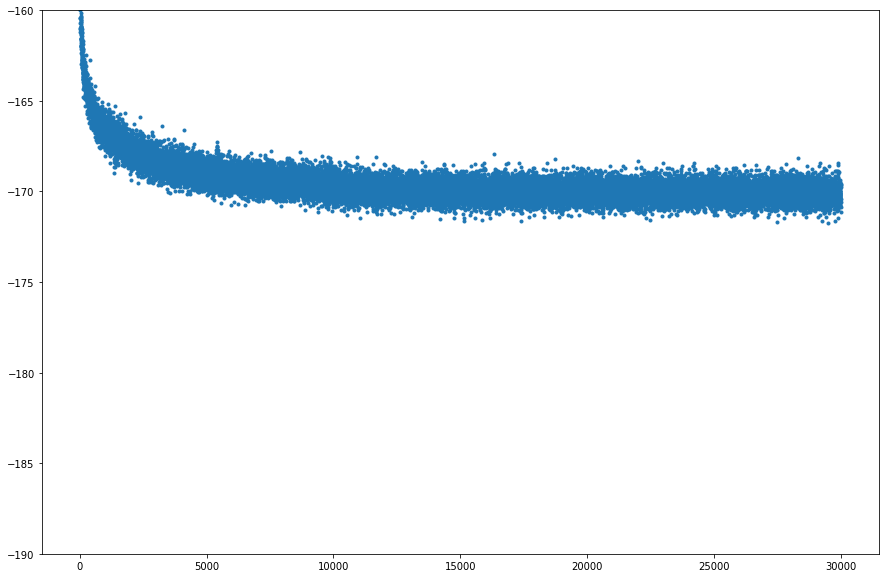

In [6]:
# Plot loss
loss = np.loadtxt(checkpoint_root + 'log/loss.csv')
plt.figure(figsize=(15, 10))
plt.plot(loss, '.')
plt.ylim(-190, -160)
plt.show()

In [7]:
# Load checkpoint
model.load(checkpoint_root + 'checkpoints/model_30000.pt')

In [6]:
# Draw samples

nth = 1

model.eval()

z_np = np.zeros((0, 60))
x_np = np.zeros((0, 66))
log_p_np = np.zeros((0,))
log_q_np = np.zeros((0,))

for i in tqdm(range(100 // nth)):
    z, log_q = model.sample(1000)
    x_np = np.concatenate((x_np, z.cpu().data.numpy()))
    log_p = model.p.log_prob(z)
    z, _ = model.flows[-1].inverse(z)
    z_np_ = z.cpu().data.numpy()
    log_p_np_ = log_p.cpu().data.numpy()
    log_q_np_ = log_q.cpu().data.numpy()
    z_np = np.concatenate((z_np, z_np_))
    log_p_np = np.concatenate((log_p_np, log_p_np_))
    log_q_np = np.concatenate((log_q_np, log_q_np_))


z_d = training_data[::nth].double().to(device)
log_p_d = model.p.log_prob(z_d)
z_d, _ = model.flows[-1].inverse(z_d)
z_d_np = z_d.cpu().data.numpy()

log_p_d_np = log_p_d.cpu().data.numpy()

100%|██████████| 100/100 [14:12<00:00,  8.52s/it]


## Use histogram to compute KLD

In [ ]:
# Estimate density
nbins = 200
hist_range = [-5, 5]
ndims = z_np.shape[1]

hists_train = np.zeros((nbins, ndims))
hists_gen = np.zeros((nbins, ndims))

for i in range(ndims):
    htrain, _ = np.histogram(z_d_np[:, i], nbins, range=hist_range, density=True);
    hgen, _ = np.histogram(z_np[:, i], nbins, range=hist_range, density=True);
    
    hists_train[:, i] = htrain
    hists_gen[:, i] = hgen

In [ ]:
for i in range(ndims):
    print(i)
    plt.plot(np.linspace(-5, 5, nbins), hists_train[:, i])
    plt.plot(np.linspace(-5, 5, nbins), hists_gen[:, i])
    plt.show()

In [ ]:
# Compute KLD
kld = np.zeros(ndims)
eps = 1e-10
kld_unscaled = np.sum(hists_train * np.log((hists_train + eps) / (hists_gen + eps)), axis=0)
kld = kld_unscaled * (hist_range[1] - hist_range[0]) / nbins

In [ ]:
# Split KLD into groups
ncarts = model.flows[-1].mixed_transform.len_cart_inds
permute_inv = model.flows[-1].mixed_transform.permute_inv
bond_ind = model.flows[-1].mixed_transform.ic_transform.bond_indices
angle_ind = model.flows[-1].mixed_transform.ic_transform.angle_indices
dih_ind = model.flows[-1].mixed_transform.ic_transform.dih_indices

kld_cart = kld[:(3 * ncarts - 6)]
kld_ = np.concatenate([kld[:(3 * ncarts - 6)], np.zeros(6), kld[(3 * ncarts - 6):]])
kld_ = kld_[permute_inv]
kld_bond = kld_[bond_ind]
kld_angle = kld_[angle_ind]
kld_dih = kld_[dih_ind]

In [ ]:
# Print resulting KLDs
print('Cartesian coorinates')
print(np.sort(kld_cart))
print('Mean:', np.mean(kld_cart))
print('Median:', np.median(kld_cart))

print('\n\nBond lengths')
print(np.sort(kld_bond))
print('Mean:', np.mean(kld_bond))
print('Median:', np.median(kld_bond))

print('\n\nBond angles')
print(np.sort(kld_angle))
print('Mean:', np.mean(kld_angle))
print('Median:', np.median(kld_angle))

print('\n\nDihedral angles')
print(np.sort(kld_dih))
print('Mean:', np.mean(kld_dih))
print('Median:', np.median(kld_dih))

In [ ]:
# Histograms of the groups
hists_train_cart = hists_train[:, :(3 * ncarts - 6)]
hists_train_ = np.concatenate([hists_train[:, :(3 * ncarts - 6)], np.zeros((nbins, 6)),
                               hists_train[:, (3 * ncarts - 6):]], axis=1)
hists_train_ = hists_train_[:, permute_inv]
hists_train_bond = hists_train_[:, bond_ind]
hists_train_angle = hists_train_[:, angle_ind]
hists_train_dih = hists_train_[:, dih_ind]

for hists in [hists_train_cart, hists_train_bond, hists_train_angle, hists_train_dih]:
    for i in range(hists.shape[1]):
        print(i)
        plt.plot(np.linspace(-5, 5, nbins), hists[:, i])
        plt.show()

## Use Gaussian KDE to compute KLD

In [7]:
# Estimate density
ndims = z_np.shape[1]

kde_train = []
kde_gen = []

for i in range(ndims):
    kernel_train = stats.gaussian_kde(z_d_np[:, i])
    kernel_gen = stats.gaussian_kde(z_np[:, i])
    
    kde_train.append(kernel_train)
    kde_gen.append(kernel_gen)

0


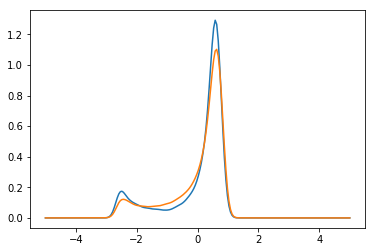

1


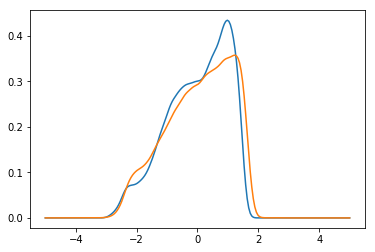

2


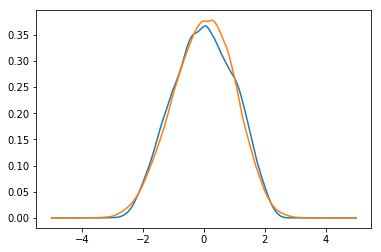

3


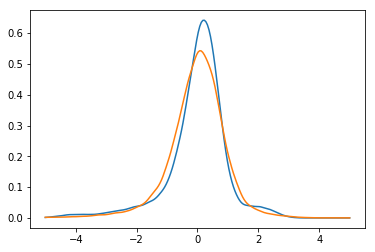

4


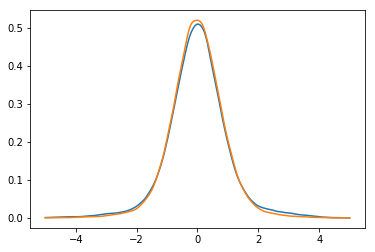

5


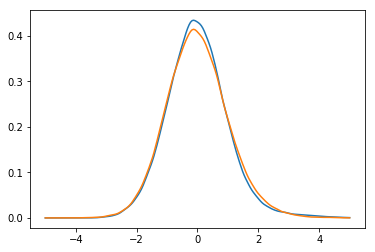

6


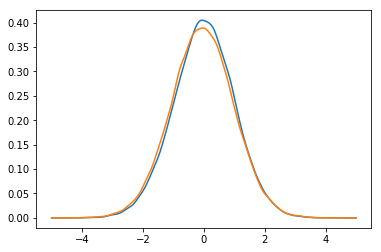

7


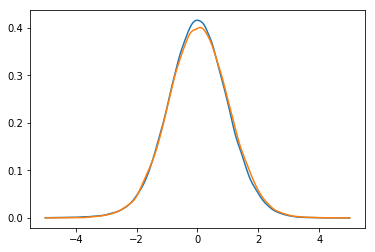

8


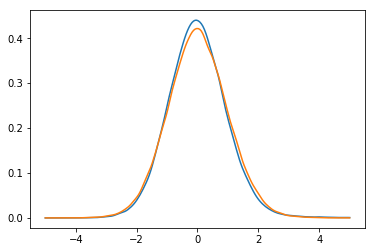

9


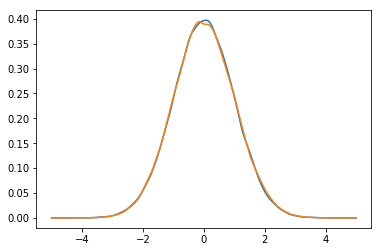

10


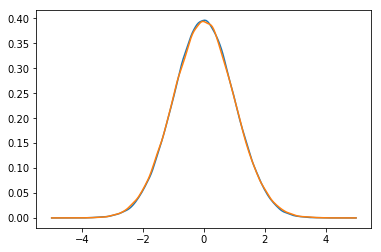

11


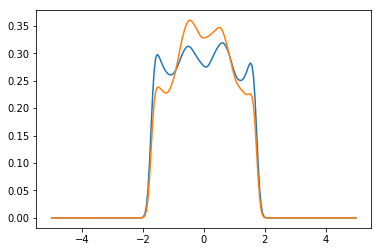

12


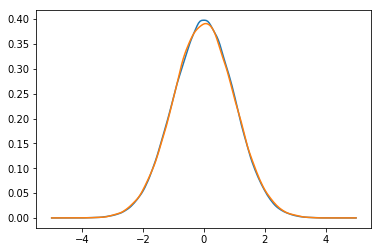

13


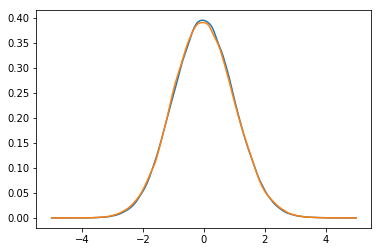

14


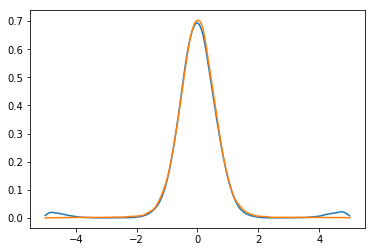

15


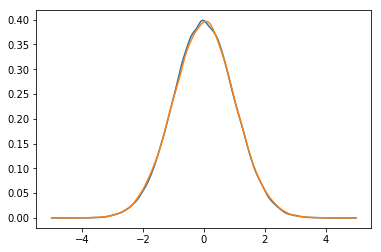

16


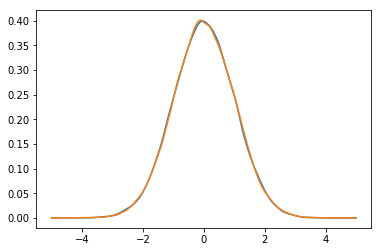

17


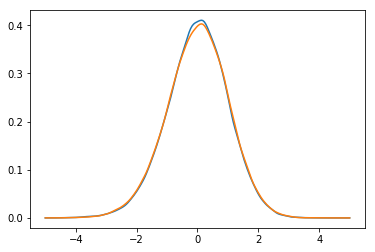

18


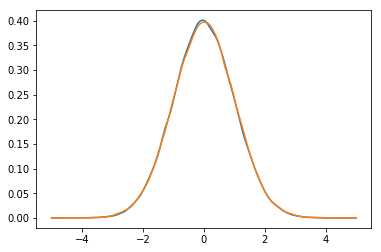

19


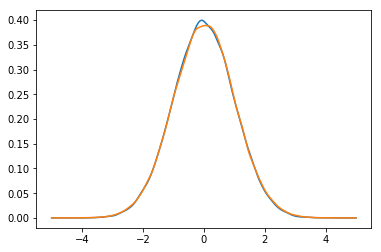

20


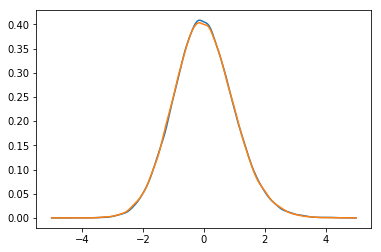

21


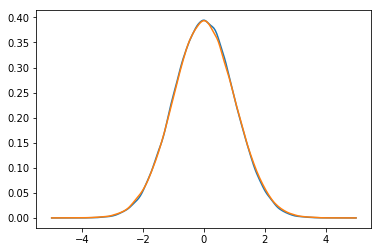

22


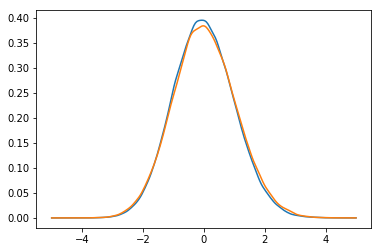

23


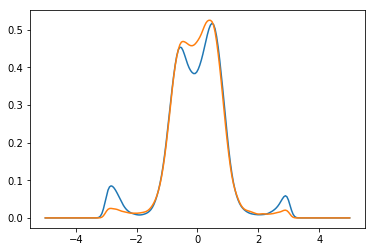

24


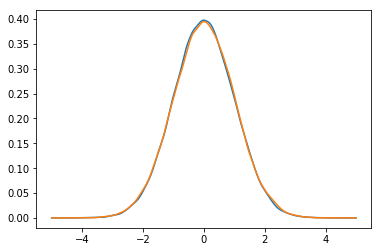

25


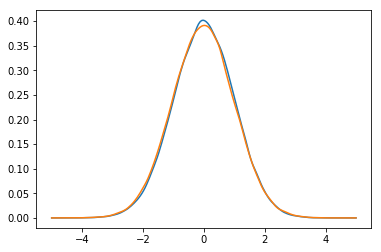

26


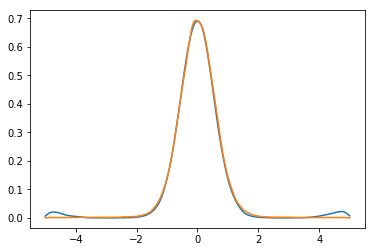

27


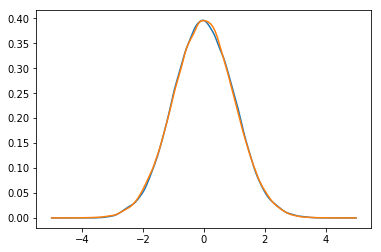

28


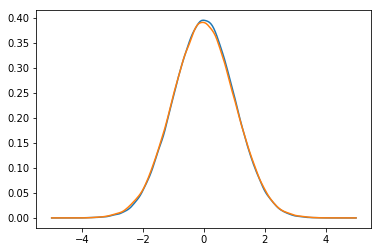

29


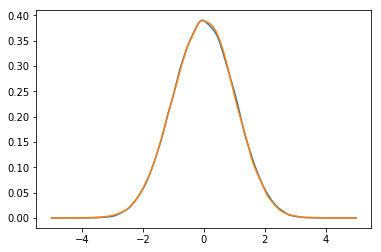

30


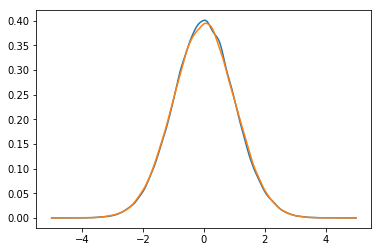

31


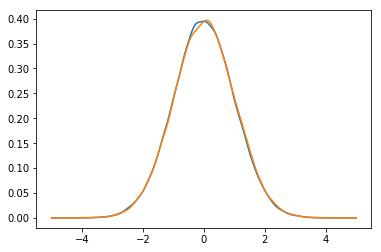

32


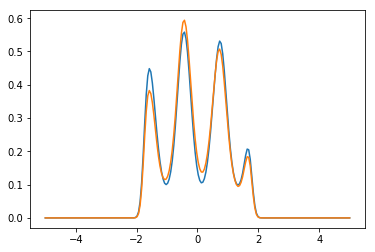

33


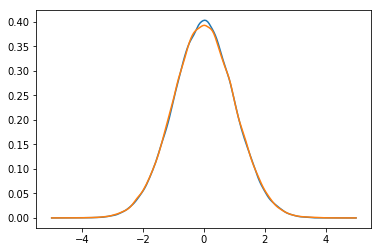

34


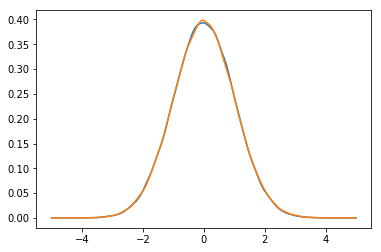

35


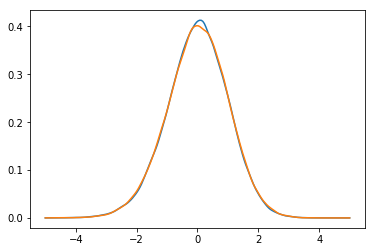

36


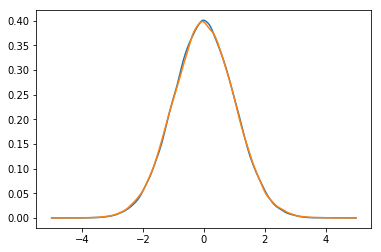

37


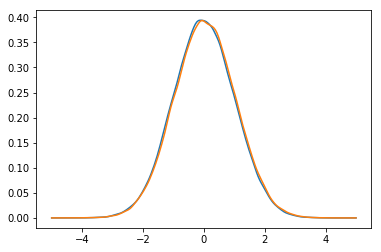

38


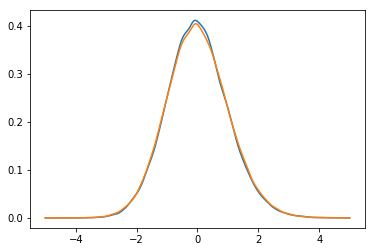

39


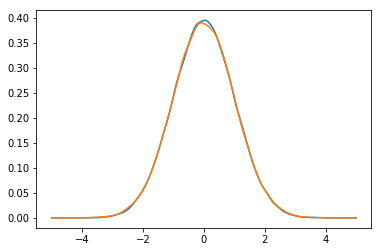

40


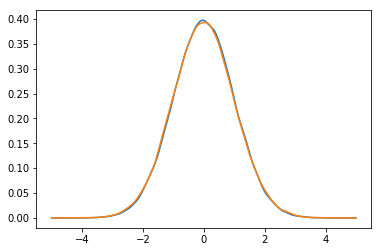

41


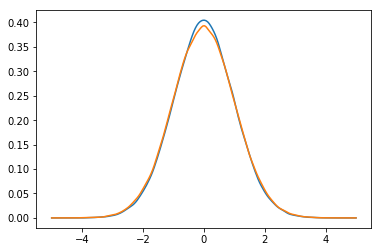

42


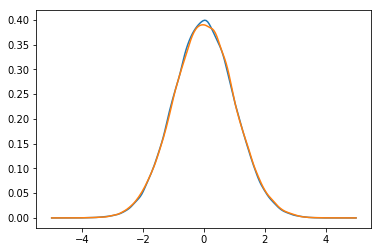

43


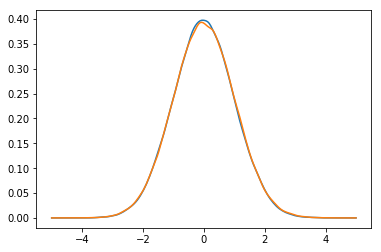

44


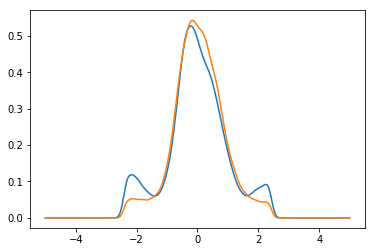

45


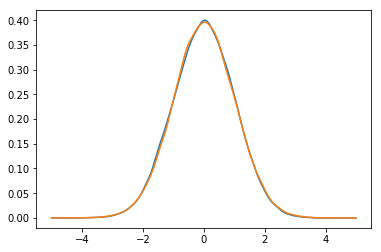

46


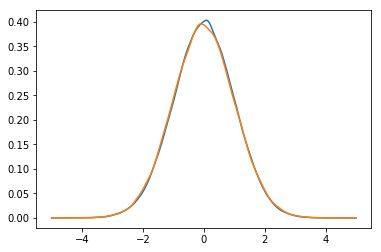

47


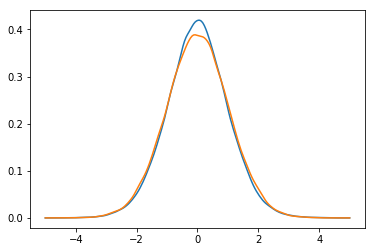

48


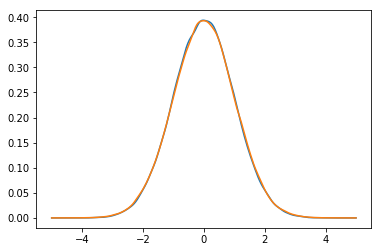

49


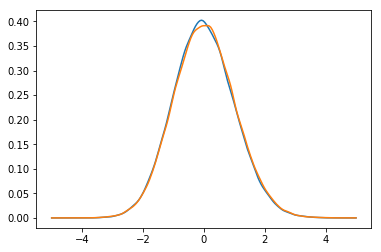

50


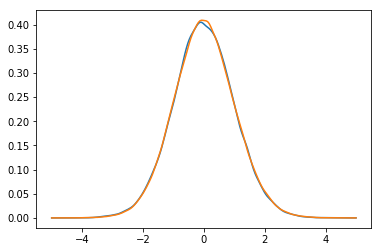

51


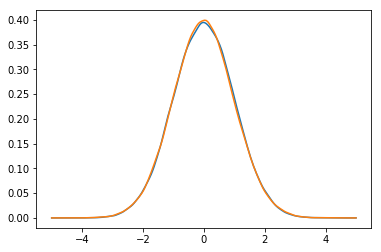

52


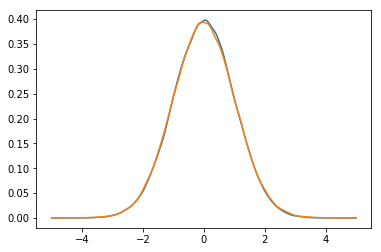

53


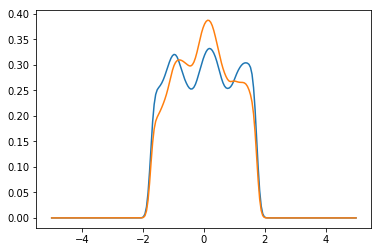

54


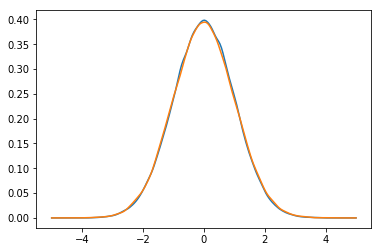

55


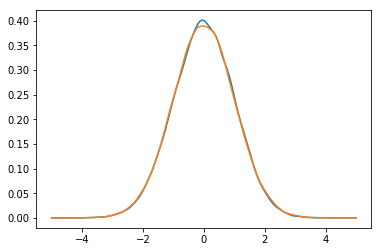

56


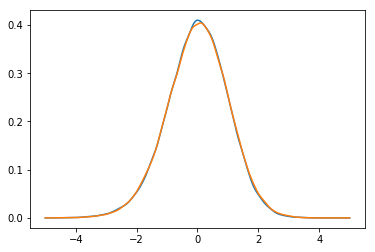

57


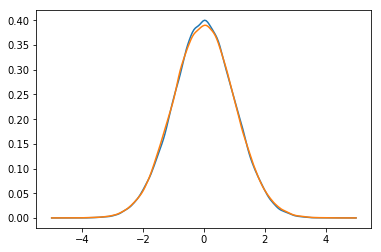

58


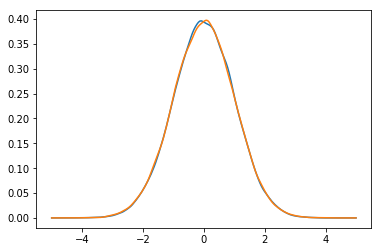

59


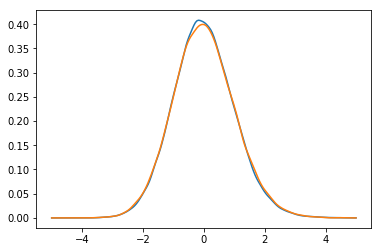

In [10]:
x = np.linspace(-5, 5, 200)
for i in range(ndims):
    print(i)
    plt.plot(x, kde_train[i].pdf(x))
    plt.plot(x, kde_gen[i].pdf(x))
    plt.show()

In [8]:
# Compute KLD
eps = 1e-10
int_range = [-5, 5]
npoints = 1000

kld = np.zeros(ndims)
x = np.linspace(int_range[0], int_range[1], npoints)

for i in tqdm(range(ndims)):
    kld_unscaled = np.sum(kde_train[i].pdf(x) * np.log((kde_train[i].pdf(x) + eps) / (kde_gen[i].pdf(x) + eps)))
    kld[i] = kld_unscaled * (int_range[1] - int_range[0]) / npoints

100%|██████████| 60/60 [06:30<00:00,  6.49s/it]


In [9]:
# Split KLD into groups
ncarts = model.flows[-1].mixed_transform.len_cart_inds
permute_inv = model.flows[-1].mixed_transform.permute_inv
bond_ind = model.flows[-1].mixed_transform.ic_transform.bond_indices
angle_ind = model.flows[-1].mixed_transform.ic_transform.angle_indices
dih_ind = model.flows[-1].mixed_transform.ic_transform.dih_indices

kld_cart = kld[:(3 * ncarts - 6)]
kld_ = np.concatenate([kld[:(3 * ncarts - 6)], np.zeros(6), kld[(3 * ncarts - 6):]])
kld_ = kld_[permute_inv]
kld_bond = kld_[bond_ind]
kld_angle = kld_[angle_ind]
kld_dih = kld_[dih_ind]

In [10]:
# Print resulting KLDs
print('Cartesian coorinates')
print(np.sort(kld_cart))
print('Mean:', np.mean(kld_cart))
print('Median:', np.median(kld_cart))

print('\n\nBond lengths')
print(np.sort(kld_bond))
print('Mean:', np.mean(kld_bond))
print('Median:', np.median(kld_bond))

print('\n\nBond angles')
print(np.sort(kld_angle))
print('Mean:', np.mean(kld_angle))
print('Median:', np.median(kld_angle))

print('\n\nDihedral angles')
print(np.sort(kld_dih))
print('Mean:', np.mean(kld_dih))
print('Median:', np.median(kld_dih))

Cartesian coorinates
[0.00503677 0.00774461 0.01794173 0.02084114 0.02168277 0.03467096
 0.06673786 0.08885765 0.13218891]
Mean: 0.043966934369659094
Median: 0.02168277011271575


Bond lengths
[0.00389373 0.00405611 0.00409078 0.00409314 0.00413864 0.0041762
 0.0043148  0.00438359 0.00439576 0.00440046 0.00440667 0.00447983
 0.0045212  0.00465564 0.00479686 0.00493304 0.00495557]
Mean: 0.004393649776794334
Median: 0.004395758966050974


Bond angles
[0.00184383 0.00198036 0.00281809 0.00317673 0.00322565 0.00323201
 0.00324733 0.00332654 0.00333287 0.0034427  0.00349577 0.00363278
 0.00363468 0.00371748 0.00375459 0.00383088 0.00385935]
Mean: 0.0032677444079648693
Median: 0.003332872518432468


Dihedral angles
[0.00288929 0.00336836 0.00380268 0.00406348 0.0041586  0.00419201
 0.0042862  0.00434514 0.00461267 0.00464762 0.0119512  0.01252207
 0.01383919 0.01887094 0.04835845 0.23042924 0.23180189]
Mean: 0.035772884149146124
Median: 0.0046126740619178855
